In [ ]:
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.utils import normalize , to_categorical
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tqdm.notebook import tqdm

from tensorflow import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
#importing dataset from Kaggle
!kaggle datasets download -d tonyromarock/tas500

 99% 1.00G/1.01G [00:09<00:00, 115MB/s]
100% 1.01G/1.01G [00:09<00:00, 110MB/s]


In [ ]:
#unziping files
!unzip \*zip && rm *.zip

Archive:  tas500.zip
  inflating: tas500v1.1/LICENSE      
  inflating: tas500v1.1/README       
  inflating: tas500v1.1/test/1527245924951752960.png  
  inflating: tas500v1.1/test/1527245948011254016.png  
  inflating: tas500v1.1/test/1527246325482020096.png  
  inflating: tas500v1.1/test/1527247480651398656.png  
  inflating: tas500v1.1/test/1527247560630494720.png  
  inflating: tas500v1.1/test/1527247570624058112.png  
  inflating: tas500v1.1/test/1527247610659371776.png  
  inflating: tas500v1.1/test/1527247630647921408.png  
  inflating: tas500v1.1/test/1528986255682796500.png  
  inflating: tas500v1.1/test/1528986310916519279.png  
  inflating: tas500v1.1/test/1528986315922284921.png  
  inflating: tas500v1.1/test/1528986341036850471.png  
  inflating: tas500v1.1/test/1528986357945288203.png  
  inflating: tas500v1.1/test/1528986360148016282.png  
  inflating: tas500v1.1/test/1528986389065382978.png  
  inflating: tas500v1.1/test/1528986401070401735.png  
  inflating: tas500v1.1

In [ ]:
img_height = 128
img_width = 128
channels = 3

In [ ]:
#helper functions to import the PNGs from their folders
def load_images(PATH, h=img_height, w=img_width):
    images_list = []
    for img_path in tqdm(glob.glob(PATH+'/*png')):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (h , w))
        images_list.append(img)
    
    return np.array(images_list)

def load_labels(PATH, h=img_height, w=img_width):
    images_list = []
    for img_path in tqdm(glob.glob(PATH+'/*png')):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (h , w),interpolation = cv2.INTER_NEAREST)
        images_list.append(img)
    
    return np.array(images_list)


train = load_images('tas500v1.1/train') 
train_labels = load_labels('tas500v1.1/train_labels_ids')
val = load_images('tas500v1.1/val')
val_labels = load_labels('tas500v1.1/val_labels_ids')


  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print('the classes are:',np.unique(train_labels))

train_labels[train_labels==255] = 23
val_labels[val_labels==255] = 23
print('new classes are:', np.unique(train_labels))

num_classes = len(np.unique(train_labels))
print('the number of classes is:', num_classes)

the classes are: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22 255]
new classes are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
the number of classes is: 24


In [ ]:
# changing the labels to categorical for classification

y_train = to_categorical(train_labels,24)

y_val = to_categorical(val_labels,24)

In [ ]:
from tensorflow.keras import Input, layers, models

model = models.Sequential()
model.add(Input(shape=(img_height, img_width, channels))) # Input layer (has cells equal to number of features)


model.add(layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())

model.add(Dropout(0.5))

model.add(UpSampling2D())

model.add(layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())

model.add(UpSampling2D())

model.add(layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')) # parameters = 32*(3*3*3+1)
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(num_classes, (1,1), activation='sigmoid'))


model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_77 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_91 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_78 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                     

C.Neural Network for MNIST dataset varies massively from the one used here. The main difference is the Up-Sampling which increases the shape of the input back to the original set values. This because the CNN is outputting an image with filter, versus the MNIST one which was simpling outputing a classification.

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy',MeanIoU(num_classes)])

In [ ]:
# training the model
history = model.fit(train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(val, y_val))

Epoch 1/20
7/7 [==============================] - 26s 3s/step - loss: 2.5323 - accuracy: 0.3539 - mean_io_u_2: 0.4711 - val_loss: 162.1571 - val_accuracy: 0.0905 - val_mean_io_u_2: 0.3435
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 1.6898 - accuracy: 0.5595 - mean_io_u_2: 0.4711 - val_loss: 124.1471 - val_accuracy: 0.0837 - val_mean_io_u_2: 0.3081
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 1.4809 - accuracy: 0.5946 - mean_io_u_2: 0.4711 - val_loss: 69.5027 - val_accuracy: 0.1086 - val_mean_io_u_2: 0.3782
Epoch 4/20
7/7 [==============================] - 8s 1s/step - loss: 1.3186 - accuracy: 0.6270 - mean_io_u_2: 0.4711 - val_loss: 26.9629 - val_accuracy: 0.1169 - val_mean_io_u_2: 0.4615
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 1.2310 - accuracy: 0.6415 - mean_io_u_2: 0.4711 - val_loss: 17.8719 - val_accuracy: 0.1023 - val_mean_io_u_2: 0.4943
Epoch 6/20
7/7 [==============================] - 8s 1s/step - loss

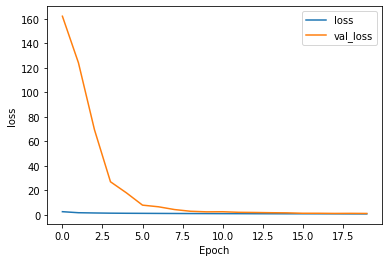

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim()
plt.legend(loc='upper right')


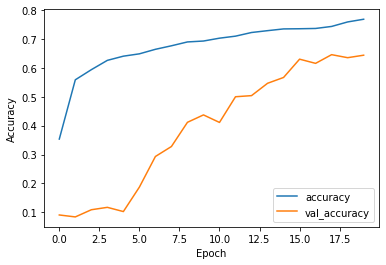

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim()
plt.legend(loc='lower right')

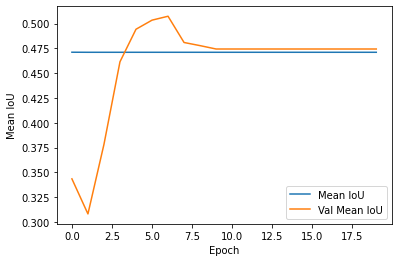

In [ ]:
plt.plot(history.history['mean_io_u_2'], label='Mean IoU')
plt.plot(history.history['val_mean_io_u_2'], label = 'Val Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.ylim()
plt.legend(loc='lower right')

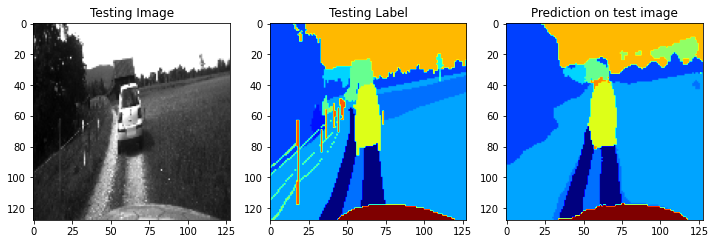

In [ ]:
import random


test_img_number = random.randint(0, len(val))
test_img = val[test_img_number]
ground_truth = val_labels[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0, :, :]
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

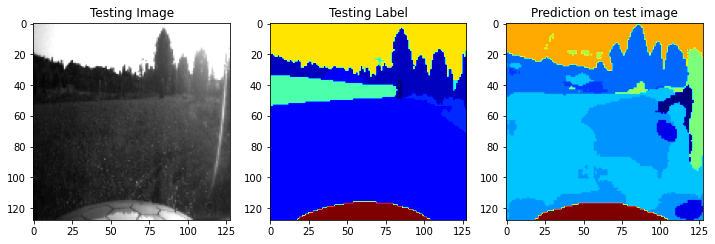

In [ ]:
test_img_number = random.randint(5, len(val))
test_img = val[test_img_number]
ground_truth = val_labels[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0, :, :]
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

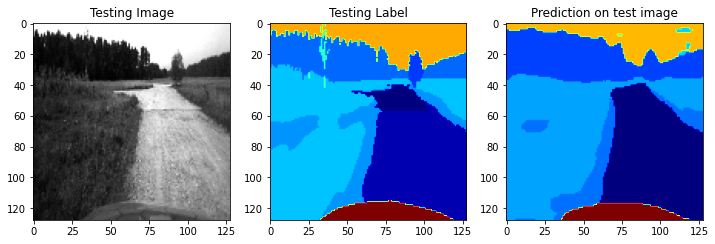

In [ ]:
test_img_number = random.randint(9, len(val))
test_img = val[test_img_number]
ground_truth = val_labels[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0, :, :]
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()